In [281]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import random
import seaborn as sns
from pathlib import Path
from scipy.interpolate import make_interp_spline
from collections import deque

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
sys.path.append("hawkeslib-master/")
from sklearn.ensemble import HistGradientBoostingRegressor

from hawkeslib import MultivariateExpHawkesProcess as MVH


if not hasattr(np, "float"):
    np.float = float
if not hasattr(np, "int"):
    np.int = int
if not hasattr(np, "bool"):
    np.bool = bool


import warnings
warnings.simplefilter("ignore", category=UserWarning)


# Methods and Classes
Eventaully be moved into a package 

In [5]:
class hawkes_system(): 

    def __init__(self, 
                 input_buffer_window_short = 10, input_buffer_window_long = 30, 
                 residual_window=15, 
                 OFI_buffer_window_short = 10, OFI_buffer_window_long = 25, 
                 theta = .1, hawkes_only_features = False, active_states =  ['MU', 'MD', "ADNM"]): 
        
        # Buffers are used for direct computations 
        # hist vectors are used for plotting later 

        # ----------- Hawkes Paramaeters 
        # Controls the functionality of only computing the hawkes intensities 
        self.hawkes_only_features  = hawkes_only_features

        # Setup default parameters, learned from previous bet fit experiments 
        self.mu = np.array([0.22742546, 0.23532417, 0.01620813])
        self.a = np.array([
            [0.19858365, 0.107086  , 0.00931048],
            [0.12042455, 0.17995655, 0.01154943],
            [0.08805226, 0.06513124, 0.17139197]
            ])
        
        self.theta= theta

        # Useful for simulating the proccess 
        self.hawkes_gamma_model = MVH()
        self.hawkes_gamma_model.set_params(mu = self.mu, A = self.a, theta = self.theta)

        # Record active states 
        self.active_states = active_states
        self.state_map = {j : i for i,j in enumerate(self.active_states )}
        self.num_states = len(self.active_states)

        # ----------- Basic Data handling
        self.i = 0 # Counts the number of states that have been successfully read (non idle)

        # Define two buffers 
        # short buffer: used for short features
        # long buffer: used for long features 
        self.input_buffer_window_short = input_buffer_window_short
        self.input_buffer_window_long  = input_buffer_window_long

        self.input_buffer_short = deque(maxlen=input_buffer_window_short) 
        self.input_buffer_long  = deque(maxlen=input_buffer_window_long) 
        self.input_hist = deque()
    
        # Reference indexs - not great
        self.time_idx =0 
        self.state_idx = 1
        self.price_off_open = 2
        self.bid_px_idx = 4
        self.ask_px_idx = 5
        self.bid_sz_idx = 6
        self.ask_sz_idx = 7
        self.mid_price_idx = 8

        # ----------- Hawkes variables and state managment 
        # Define hawkes inputs, just derived from the current buffers 
        self.t_c = deque() 
        self.t_start = None # actual time value to start from 

        # Dealing with states 
        self.current_state = np.zeros((self.num_states, self.num_states))
        self.state_up_to_date = False #boolean to determine if the state has been updated yet 
        self.state_hist = deque()

        # ---------- Residual and compensator managment
        # Compensator 
        self.dLambda_hist = deque() 
        self.dLambda_buffer = deque(maxlen=3) 

        # Residual and delta setup 
        self.residual_window = residual_window

        # used directly for computing compensator values 
        self.residual_buffer = [deque(maxlen=residual_window) for i in range(self.num_states)]
        self.residual_hist = [deque() for i in range(self.num_states)] # stores residual and time values
        [element.append(0.0) for element in self.residual_buffer]

        # Just used for storing the delta history 
        self.delta_hist = [deque() for i in range(self.num_states)]
        self.delta_buffer = [deque(maxlen=2) for i in range(self.num_states)]
        self.one_step_res = [deque() for i in range(self.num_states)]

        # ---------- Output feature managment 
        # Price features
        self.open_price = None 

        # Feature history 
        self.feature_hist = deque()

        # Order flow imbalance
        self.OFI_buffer_window_short  = OFI_buffer_window_short
        self.OFI_buffer_window_long = OFI_buffer_window_long
        self.OFI_buffer_short = deque(maxlen = OFI_buffer_window_short)
        self.OFI_buffer_long = deque(maxlen  = OFI_buffer_window_long)


    def read_pd_raw(self, row_curr : pd.DataFrame):
        """
        Reads in rows from BBO -1s order book information, parses and updates all buffers and variables 
        """
        # Check if row is valid
        valid_ind =  row_curr[['ts_event', 'price', 'bid_px_00', 'ask_px_00', 'ts_recv', 'bid_sz_00', 'ask_sz_00' ]].isna().sum(axis=1)
        if (valid_ind != 0).any(): 
            return 

        # If row is valid compute mid prie 
        row_curr['mid_price'] = (row_curr['bid_px_00'] + row_curr['ask_px_00']) / 2
        row_curr_temp =  row_curr[['ts_recv', 'price', 'bid_px_00', 
                                   'ask_px_00', 'bid_sz_00', 'ask_sz_00', 
                                   'mid_price']].to_numpy()[0]
        
        # Final format for row_curr_arr (time_sec, state, price_off_open, price, bid_px, ask_px, bid_sz, ask_sz, mid_price) 

        # Allocate 0s want to include space for the 
        row_curr_arr = np.zeros(len(row_curr_temp)+2, dtype = float) # size 9 

        # Fill with numeric values 
        row_curr_arr[3:] = row_curr_temp[1:] # 3-10 filled with values

        # Convert to time since midnight 
        dt_seconds = np.datetime64(row_curr_temp[0], 's')       

        # Add second values, 0 filled 
        row_curr_arr[self.time_idx] = (dt_seconds.astype('datetime64[s]') - dt_seconds.astype('datetime64[D]'))/ np.timedelta64(1, 's')

        if self.i == 0: 
            self.open_price = row_curr_arr[self.mid_price_idx]
            row_curr_arr[self.state_idx] = -10
            row_curr_arr[2] = row_curr_arr[self.mid_price_idx] - self.open_price

            self.input_buffer_short.append(row_curr_arr)
            self.input_buffer_long.append(row_curr_arr)
            self.i += 1 
            return 
        

        # Add the price off open   
        row_curr_arr[2] = row_curr_arr[self.mid_price_idx] - self.open_price
        row_prev_arr = self.input_buffer_short[-1]

        # Compute states based on short buffer value 
        if row_prev_arr[self.mid_price_idx]  < row_curr_arr[self.mid_price_idx]: 
            # mid price increases 
            row_curr_arr[self.state_idx] = 0 # MU 
        elif row_curr_arr[self.mid_price_idx] < row_prev_arr[self.mid_price_idx]: 
            # mid price down 
            row_curr_arr[self.state_idx] = 1 # MD 
        elif ((row_curr_arr[self.mid_price_idx] == row_prev_arr[self.mid_price_idx]) 
              & (row_curr_arr[self.ask_sz_idx] < row_prev_arr[self.ask_sz_idx])): 
            # if the mid price stays the same,  and the current ask size has decreased, then Ask Down No Movement 
            row_curr_arr[self.state_idx] = 2 # ADNM 
        else: # set to idle state 
            row_curr_arr[self.state_idx] = -10 # IDLE 

        # Set start date if needed
        if self.t_start is None and row_curr_arr[self.state_idx] != -10: 
            # First non idle time 
            self.t_start = row_curr_arr[self.time_idx]
        elif row_curr_arr[self.state_idx] != -10: 
            self.main_update(row_curr_arr)

        # Update long buffer 
        self.input_buffer_short.append(row_curr_arr)
        self.input_buffer_long.append(row_curr_arr)
        self.input_hist.append(row_curr_arr)
        
        # Update i counter 
        self.i += 1

    def main_update(self, row_curr_arr): 
        '''
        Responsible for updating hawkes states, compensators, deltas, and buffers 
        '''
        # if t_start already set and state isnt idle
        # add the time since t_start and the state  - this is the result that will be use for the hawkes proccess directly 
        t_ = row_curr_arr[self.time_idx] - self.t_start 
        c_ = row_curr_arr[self.state_idx]
        self.t_c.append(np.array([t_, c_ ]))

        # Tell the rest of the program the state is now out of date 
        self.state_up_to_date = False 

        # Update the states
        self.update_states()

        # Update compensator increments 
        self.update_compensator_inc()

        # Update the residuals 
        self.update_residuals_delta()

    def update_states(self):
        # just a functin of t and c and the parameters 
        if self.state_up_to_date: 
            return  ""
        if len(self.t_c) < 2: 
            return ""
        
        t_cur, c_cur = self.t_c[-1]
        t_prev, c_prev = self.t_c[-2]

        c_cur = int(c_cur)

        dt = t_cur - t_prev
        if dt < 0 : 
            print('non montone')
        else:
            # Compute new state and update
            int_state_decay = np.exp(-self.theta * dt) 
            self.current_state = self.current_state * int_state_decay
            self.current_state[:, c_cur] = self.current_state[:, c_cur] +  1 
            
            # add to state history 
            self.state_hist.append(self.current_state.copy())
            self.state_up_to_date = True 

            #print("Update state successful")

            # This stores intensities AFTER the update 

    def update_features(self):
        """
        Outputs variables at current state 
        1. Hawkes intesities for each event
        2. Compensated intensties 
        3. Mid price movement off start 
        4. Derivative for mid price (with smoothing applied )
        5. Order-flow imbalance (signed volume) 
        6. Queue (book) imbalance (top of book)
        """

        if len(self.t_c) <= 2:
            return  
    
        if len(self.input_buffer_short) < 2:
            return

        t_cur, c_cur = self.t_c[-1]
        
        # -------- Intensities  
        lam = np.sum(self.current_state * self.theta  * self.a, axis = 1)  + self.mu
        lam_compensated = np.zeros(self.num_states)

        for i in range(self.num_states):
            if len(self.delta_buffer[i])  >= 1:
                lam_compensated[i] =  lam[i] *self.delta_buffer[i][-1]
        
        intensity_spread = lam[0] - lam[1]
        intensity_spread_compensated = lam_compensated[0] - lam_compensated[1]

        if not self.hawkes_only_features: 
            # -------- Price off movement 
            price_off_open = self.input_buffer_short[-1][self.price_off_open]

            # --------  Mid price derivative + short term volatility 
            price_mov_derivative_s = np.nan  
            vol_s = np.nan 
            momentum_s = np.nan 

            if len(self.input_buffer_short ) >= self.input_buffer_window_short: 
                mid_prices_s = np.array(self.input_buffer_short)[:, self.mid_price_idx]
                
                # Price derivates 
                x_s = np.arange(self.input_buffer_window_short)
                price_mov_derivative_s, intercept = np.polyfit(x_s, mid_prices_s, 1)

                # Short term volatility 
                vol_s = np.std(np.diff(mid_prices_s))

                # momentum 
                window_m_s = min(5, self.input_buffer_window_short - 1)
                if window_m_s > 0: momentum_s = mid_prices_s[-1] - mid_prices_s[-1 - window_m_s]


            price_mov_derivative_l = np.nan  
            vol_l = np.nan 
            momentum_l = np.nan 

            if len(self.input_buffer_long ) >= self.input_buffer_window_long: 
                mid_prices_l = np.array(self.input_buffer_long)[:, self.mid_price_idx]
                
                # Price derivates 
                x_l = np.arange(self.input_buffer_window_long)
                price_mov_derivative_l, intercept = np.polyfit(x_l, mid_prices_l, 1)

                # Short term volatility 
                vol_l = np.std(np.diff(mid_prices_l))

                # momentum 
                momentum_l = mid_prices_l[-1] - mid_prices_l[0]

            # -------- Order flow imablance (OFI)
            OFI_inc = 0 
            current_arr = self.input_buffer_short[-1]
            prev_arr = self.input_buffer_short[-2] 

            if current_arr[self.bid_px_idx] > prev_arr[self.bid_px_idx]: OFI_inc += current_arr[self.bid_sz_idx]
            elif current_arr[self.bid_px_idx] < prev_arr[self.bid_px_idx]: OFI_inc  -= prev_arr[self.bid_sz_idx]

            if current_arr[self.ask_px_idx] < prev_arr[self.ask_px_idx]: OFI_inc -= prev_arr[self.ask_sz_idx]
            elif current_arr[self.ask_px_idx] > prev_arr[self.ask_px_idx]: OFI_inc += current_arr[self.ask_sz_idx] 
            
            # ---- store into BOTH buffers
            self.OFI_buffer_short.append(OFI_inc)
            self.OFI_buffer_long.append(OFI_inc)

            # ---- compute short cumulative
            OFI_cum_short = np.nan
            if len(self.OFI_buffer_short) >= self.OFI_buffer_window_short:
                OFI_cum_short = float(np.sum(self.OFI_buffer_short))

            # ---- compute long cumulative
            OFI_cum_long = np.nan
            if len(self.OFI_buffer_long) >= self.OFI_buffer_window_long:
                OFI_cum_long = float(np.sum(self.OFI_buffer_long))


            # -------- Queue imbalance (QI)
            bid_sz = current_arr[self.bid_sz_idx]
            ask_sz = current_arr[self.ask_sz_idx]
            QI = bid_sz / (bid_sz + ask_sz) if bid_sz + ask_sz > 0 else .5 

            # LQ ratio
            liq_ratio = bid_sz / max(ask_sz, 1e-9)
            liq_ratio = np.clip(liq_ratio,0, 100)

            # -------- Bid spread 
            spread = current_arr[self.ask_px_idx] - current_arr[self.bid_px_idx]

            # ------- Create and export feature stack 
            # (lam, lam_compensated, price_mov_derivative, OFI, QI, mid_price, price_off_open, t_cur )
            features = np.concatenate((lam, lam_compensated, 
                                    np.array(
                                        [intensity_spread, intensity_spread_compensated, 
                                         spread, liq_ratio,
                                         OFI_inc, OFI_cum_short, OFI_cum_long, 
                                         QI, current_arr[self.mid_price_idx], price_off_open,
                                         price_mov_derivative_s, vol_s, momentum_s,
                                         price_mov_derivative_l, vol_l, momentum_l,
                                         t_cur]
                                    )))
        else: 
            features = np.concatenate((lam, lam_compensated))

        self.feature_hist.append(features)

    def update_compensator_inc(self): 
        """
        This gives us the per interval delta Lambda 
        Or how much area under the intensity curve is added between events 
        """
        if len(self.state_hist) < 2: 
            return 

        # Only update if states are up to date 
        if self.state_up_to_date: 
            # Get state variable 
            s_plus_prev = self.state_hist[-2]

            # Get recent t values and one previous 
            t_cur, c_cur = self.t_c[-1]
            t_prev, c_prev = self.t_c[-2]

            dt = t_cur - t_prev

            if dt <= 0:
                print("non monotone")
                # Non-monotone times → better to bail than accumulate nonsense
                return 
            

            decay_factor = 1.0 - np.exp(-self.theta * dt )
            
            base_term = self.mu * dt                
            excite_term = (self.a * s_plus_prev).sum(axis=1)  * decay_factor

            dLambda = np.zeros((1,  self.num_states+ 1 ))[0]

            dLambda[0:self.num_states] = base_term + excite_term   
            dLambda[-1] = c_cur
            
            # Store in history (vector per interval)
            self.dLambda_hist.append(np.concatenate((dLambda, np.array([t_cur]))))
            self.dLambda_buffer.append(dLambda)

    def update_residuals_delta(self):
        # 1. guard
        if len(self.dLambda_buffer) < 2 :
            return

        # Get most recent dLambd value 
        dLambda = self.dLambda_buffer[-1]

        # Get most recent c value 
        t_cur, c_cur = self.t_c[-1]
        k = int(c_cur)

        # Update residuals for all states 
        for j in range(self.num_states):
            new_res = self.residual_buffer[j][-1] + dLambda[j]
            self.residual_buffer[j][-1] = new_res

        # Grab the resiudal for the state that just fired 
        state_k_residuals = np.array(self.residual_buffer[k])

        # Grab the most recent residual 
        raw_res = state_k_residuals[-1]
        
        # Want to now compute the most recent delta, and the one step error 

        # First check if we have a full window yet 
        if len(state_k_residuals) >= self.residual_window:

            # Compute the delta of the most recent window 
            mean_res = state_k_residuals.mean()
            if mean_res <=0 : 
                return 
            delta_k = 1.0 / state_k_residuals.mean()

            # Add it to the history 
            self.delta_hist[k].append(np.array([delta_k, t_cur]))

            self.delta_buffer[k].append(delta_k)

            # If we have enough deltas compute the one step resiudal 
            if len(self.delta_buffer[k]) > 1:

                # Grab previously computed delta 
                prev_delta = self.delta_buffer[k][-2]

                # Compensate current residual with previous delta 
                comp_res = raw_res * prev_delta

                # Get the one step error and append 
                self.one_step_res[k].append(np.array([comp_res, t_cur]))


        # For the state that just fired, resent the cummulative count 
        self.residual_hist[k].append(np.array([raw_res, t_cur]))
        self.residual_buffer[k].append(0.0)
        

In [ ]:
def get_feature_frames(hwk: hawkes_system): 
    
    feature_hist_arr = np.array(hwk.feature_hist)

    feature_names = [
        "lam_0", "lam_1", "lam_2",
        "lam_comp_0", "lam_comp_1", "lam_comp_2",
        "intensity_spread", "intensity_spread_compensated",
        "spread", "liq_ratio",
        "OFI_inc", "OFI_cum_short", "OFI_cum_long", "QI",
        "mid_price", "price_off_open",
        "price_mov_derivative_s", "vol_s", "momentum_s",
        "price_mov_derivative_l", "vol_l", "momentum_l",
        "t_cur",
    ]
    raw_features_df = pd.DataFrame(feature_hist_arr, columns=feature_names)

    # drop rows with NaNs
    raw_features_df = raw_features_df[~raw_features_df.isnull().any(axis=1)].copy()

    # sort by time ON THE MAIN DF
    raw_features_df = raw_features_df.sort_values("t_cur").reset_index(drop=True)

    # Create the actual output features, compute the average of the NEXT 5s mid price 
    raw_features_df["avg_5_ticks"] = (
        raw_features_df["mid_price"]
        .shift(-1)       # start at t+1
        .iloc[::-1]
        .rolling(5)      # 5 future ticks
        .mean()
        .iloc[::-1]
    )

    # Get 10 second average 
    raw_features_df["avg_10_ticks"] = (
        raw_features_df["mid_price"]
        .shift(-1)       # start at t+1
        .iloc[::-1]
        .rolling(10)      # 10 future ticks
        .mean()
        .iloc[::-1]
    )

    # Drop NA 
    raw_features_df = raw_features_df[~raw_features_df["avg_5_ticks"].isna()].reset_index(drop=True)
    raw_features_df = raw_features_df[~raw_features_df["avg_10_ticks"].isna()].reset_index(drop=True)

    # Compute the delta between the current price, and the next 5 seconds average + again for 10 second average 
    raw_features_df["5s_price_delta"] = raw_features_df["avg_5_ticks"] - raw_features_df["mid_price"] 
    raw_features_df["10s_price_delta"] = raw_features_df["avg_10_ticks"] - raw_features_df["mid_price"] 

    return raw_features_df.reset_index(drop=True) 


# Dataframe construction

In [9]:
root_training = "dataset_bb0_1/APPL_MIX_1s_training"
root_validation = "dataset_bb0_1/APPL_MIX_1s_validation"
start_idx = 50
hour_per_day = 5


In [10]:
daily_feature_list = []

num_files = len(os.listdir(root_training))
for j, filename in enumerate(os.listdir(root_training)):
    path = f"{root_training}/{filename}"
    symbol_day = filename.split(".")[0]

    # Raw per-day feed
    raw_day_df = pd.read_csv(path, compression='zstd')

    # Define hawkes system 
    hwk = hawkes_system()

    end_idx = min(start_idx + 3600*hour_per_day, len(raw_day_df)-1)

    for i in range(start_idx, end_idx):
        row = raw_day_df.loc[[i], :]
        hwk.read_pd_raw(row_curr=row)
        hwk.update_features()

    # Per-day feature frame
    day_features = get_feature_frames(hwk)
    day_features.to_csv(f"dataset_ml/training_data_raw/{symbol_day}.csv")

    daily_feature_list.append(day_features)

    print(np.round((j+1)/num_files, 2))

# Final merge
full_training_df = pd.concat(daily_feature_list, ignore_index=True)
full_training_df.to_csv("dataset_ml/training_data_hwks.csv")

0.06666666666666667
0.13333333333333333
0.2
0.26666666666666666
0.3333333333333333
0.4
0.4666666666666667
0.5333333333333333
0.6
0.6666666666666666
0.7333333333333333
0.8
0.8666666666666667
0.9333333333333333
1.0


In [11]:
daily_feature_list = []

num_files = len(os.listdir(root_validation))
for j, filename in enumerate(os.listdir(root_validation)):
    path = f"{root_validation}/{filename}"
    symbol_day = filename.split(".")[0]

    # Raw per-day feed
    raw_day_df = pd.read_csv(path, compression='zstd')

    # Define hawkes system 
    hwk = hawkes_system()

    end_idx = min(start_idx + 3600*hour_per_day, len(raw_day_df)-1)

    for i in range(start_idx, end_idx):
        row = raw_day_df.loc[[i], :]
        hwk.read_pd_raw(row_curr=row)
        hwk.update_features()

    # Per-day feature frame
    day_features = get_feature_frames(hwk)
    day_features.to_csv(f"dataset_ml/validation_data_raw/{symbol_day}.csv")

    daily_feature_list.append(day_features)

    print(np.round((j+1)/num_files, 2))

# Final merge
full_validation_df = pd.concat(daily_feature_list, ignore_index=True)
full_validation_df.to_csv("dataset_ml/validation_data_hwks.csv")

0.14
0.29
0.43
0.57
0.71
0.86
1.0


# Baseline Models 

In [284]:
training_data = pd.read_csv('dataset_ml/training_data_hwks.csv', index_col =0)
validation_data = pd.read_csv('dataset_ml/validation_data_hwks.csv', index_col =0)

training_data = training_data[training_data['intensity_spread_compensated'] != 0]
training_data = training_data[training_data['lam_comp_2'] !=0]  
training_data.drop(['mid_price',  'price_off_open'], axis = 1, inplace =True)

validation_data = validation_data[validation_data['intensity_spread_compensated'] != 0]
validation_data= validation_data[validation_data['lam_comp_2'] !=0]  
validation_data.drop(['mid_price',  'price_off_open'], axis = 1, inplace =True)


## 5s Regression

In [285]:
# Copy so we don't mutate your originals
train = training_data.copy()
valid = validation_data.copy()

drop_col = ['lam_0', 'lam_1', 'intensity_spread', 't_cur', 'spread', 'intensity_spread_compensated']
hawkes_cols = ['lam_comp_2', 'lam_comp_0', 'lam_comp_1']
target_col = '10s_price_delta'

raw_feature_col = ['avg_5_ticks', 'avg_10_ticks', '5s_price_delta', '10s_price_delta']


In [286]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def run_linear_model(feature_cols, name):
    # Select features
    X_train = train[feature_cols].copy()
    y_train = train[target_col]

    X_val = valid[feature_cols].copy()
    y_val = valid[target_col]
    
    # -------- Standard scaling (no leakage) --------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)   # fit only on train
    X_val_scaled   = scaler.transform(X_val)         # apply to validation

    # -------- Linear model --------
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    pred = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, pred)
    r2 = r2_score(y_val, pred)

    print(f"\n=== {name} ===")
    print("Num features:", len(feature_cols))
    print("MSE:", mse)
    print("R²:", r2)

    return model, scaler, mse, r2

def run_gb_model(feature_cols, name):
    # Select features
    X_train = train[feature_cols].copy().values
    y_train = train[target_col].values

    X_val = valid[feature_cols].copy().values
    y_val = valid[target_col].values

    # -------- Gradient boosting regressor (non-linear) --------
    model = HistGradientBoostingRegressor(
        max_depth=6,             # allow some complexity, but not crazy
        learning_rate=0.05,
        max_iter=300,
        min_samples_leaf=50,     # regularization against noise
        l2_regularization=1.0,
        random_state=42
    )

    model.fit(X_train, y_train)

    pred = model.predict(X_val)
    mse = mean_squared_error(y_val, pred)
    r2 = r2_score(y_val, pred)

    print(f"\n=== {name} (HistGradientBoostingRegressor) ===")
    print("Num features:", len(feature_cols))
    print("MSE:", mse)
    print("R²:", r2)

    return model, mse, r2


In [287]:
feature_cols_A = [c for c in train.columns 
                  if c not in drop_col  
                  and c != target_col
                  and c not in raw_feature_col]

model, scaler, mse, r2 = run_linear_model(feature_cols_A, 
                                        "Model A (no drop_col features)")

model, mse, r2 = run_gb_model(feature_cols_A, "Model A (no drop_col features)")



=== Model A (no drop_col features) ===
Num features: 15
MSE: 0.004177257601573856
R²: 0.24614611928647456

=== Model A (no drop_col features) (HistGradientBoostingRegressor) ===
Num features: 15
MSE: 0.004472008643916497
R²: 0.1929535134412811


In [254]:
coef_df = pd.DataFrame({
    "feature": feature_cols_A,
    "max_abs_coef": model_A.coef_,
})
coef_df

,feature,max_abs_coef
0,lam_2,5.946204e-02
1,lam_comp_0,6.261809e-03
2,lam_comp_1,-1.407918e-02
3,lam_comp_2,-6.930260e-03
4,liq_ratio,-1.491801e-04
5,OFI_inc,2.611888e-07
6,OFI_cum_short,3.788549e-06
7,OFI_cum_long,2.095459e-07
8,QI,-8.063120e-03
9,price_mov_derivative_s,8.652947e-02


In [360]:
feature_cols_B = [c for c in train.columns
                  if c not in hawkes_cols
                  and c not in drop_col
                  and c != target_col
                  and c not in raw_feature_col]

model_B, mse_B, r2_B = run_linear_model(feature_cols_B, 
                                        "Model B (no Hawkes features)")

KeyError: 'dir'

In [256]:
feature_cols_C = hawkes_cols

model_C, mse_C, r2_C = run_linear_model(feature_cols_C,
                                        "Model C (Hawkes-only)")


=== Model C (Hawkes-only) ===
Num features: 3
MSE: 0.005536717971846841
R^2: 0.0008094478251763348


## 5s classifier 

In [472]:
epsilon = .03
drop_col = ['lam_0', 'lam_1', 'lam_comp_2', 'intensity_spread', 
            't_cur', 'spread', 'intensity_spread_compensated', 'momentum_s', 'vol_l', 
            'OFI_cum_short', 'OFI_inc', 'momentum_l', 'price_mov_derivative_s', 'OFI_cum_long', 'price_mov_derivative_l']
raw_feature_col = ['avg_5_ticks', 'avg_10_ticks', '5s_price_delta', '10s_price_delta']
target_col = 'dir'



training_data_5s = training_data.copy()
validation_data_5s = validation_data.copy()

(-0.2, 0.2)

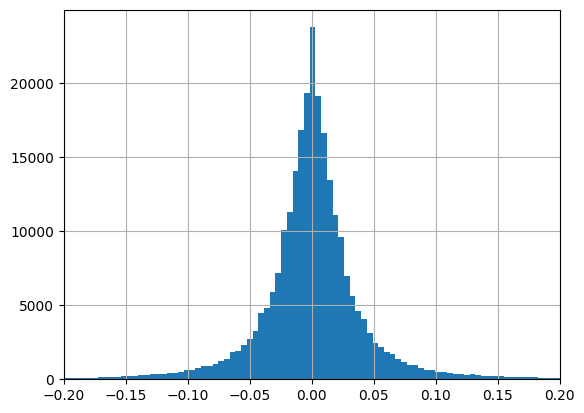

In [473]:
ax = training_data_5s['10s_price_delta'].hist(bins=500)
ax.set_xlim([-0.2, 0.2])   # example limits


In [ ]:

training_data_5s['dir'] = 0 
training_data_5s.loc[training_data_5s['10s_price_delta'] > epsilon , 'dir'] = 1 
training_data_5s.loc[training_data_5s['10s_price_delta'] < -epsilon , 'dir'] = 1

validation_data_5s['dir'] = 0 
validation_data_5s.loc[validation_data_5s['10s_price_delta'] > epsilon , 'dir'] = 1 
validation_data_5s.loc[validation_data_5s['10s_price_delta'] < -epsilon , 'dir'] = 1

training_data_5s = training_data_5s.drop(drop_col + raw_feature_col, axis =1).sample(frac=1)
validation_data_5s = validation_data_5s.drop(drop_col + raw_feature_col, axis =1).sample(frac=1)

print(training_data_5s['dir'].value_counts())
print(validation_data_5s['dir'].value_counts())

dir
0    179242
1     79593
Name: count, dtype: int64
dir
0    76225
1    42559
Name: count, dtype: int64


### Correlations

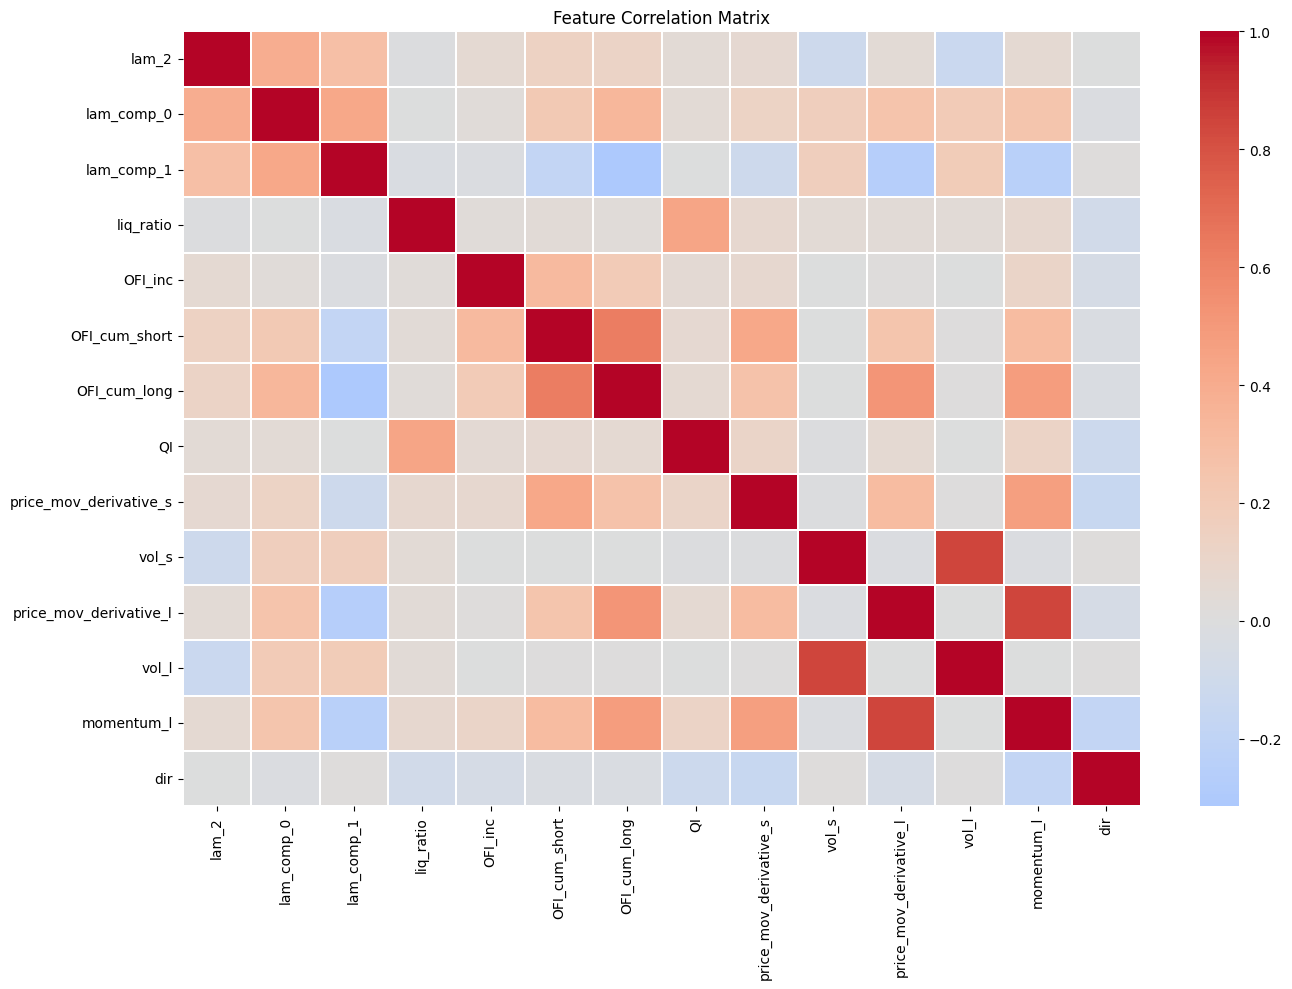

In [312]:
corr = training_data_5s.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    annot=False,
    cmap="coolwarm",
    linewidths=0.3,
    center=0
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [117]:
threshold = .8
high_corr = []
cols = corr.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):   # avoid duplicates + diagonal
        c = corr.iloc[i, j]
        if abs(c) > threshold:
            high_corr.append((cols[i], cols[j], c))

high_corr

[('vol_s', 'vol_l', np.float64(0.8415442214960177)),
 ('price_mov_derivative_l', 'momentum_l', np.float64(0.8455897655941423))]

### Training

In [475]:
counts = training_data_5s[target_col].value_counts()
min_count = counts.min()   # smallest class count

# For each class, randomly sample min_count rows
training_data_5s = (
    training_data_5s.groupby(target_col)
        .apply(lambda x: x.sample(min_count, replace=False))
        .reset_index(drop=True)
)


# training_data_5s = training_data_5s[training_data_5s['dir'] !=0]
# validation_data_5s = validation_data_5s[validation_data_5s['dir'] !=0]


# training_data_5s['dir'].value_counts()

C:\Users\isaac\AppData\Local\Temp\ipykernel_13800\1553969709.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, replace=False))


In [476]:
X_train = validation_data_5s.drop(target_col, axis =1 )
Y_train = validation_data_5s[target_col]

X_test = training_data_5s.drop(target_col, axis =1 )
Y_test = training_data_5s[target_col]

Test two classifiers, with and without the hawkes features 

In [477]:
# If X_train is a DataFrame, get feature names from columns
if hasattr(X_train, "columns"):
    feature_names = X_train.columns.tolist()
else:
    # otherwise you need to define this list yourself
    feature_names = [f"f_{i}" for i in range(X_train.shape[1])]

log_reg = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.1,                 # stronger regularization -> more zeros
    class_weight="balanced",
    max_iter=5000,
    n_jobs=-1,
)

log_reg_pipe = Pipeline([
    ("scaler", StandardScaler()),   # fit ONLY on training data
    ("log_reg", log_reg),
])

# Fit on train
log_reg_pipe.fit(X_train, Y_train)

# Predict on test
y_pred_lr = log_reg_pipe.predict(X_test)

print("\n=== L1 Logistic Regression ===")
print("Overall accuracy:", accuracy_score(Y_test, y_pred_lr))
print("\nClassification report:")
print(classification_report(Y_test, y_pred_lr, digits=2))


# -------------------------------
# 3) Inspect feature coefficients (importance)
# -------------------------------
lr = log_reg_pipe.named_steps["log_reg"]
coefs = lr.coef_  # shape: (n_classes, n_features)

# aggregate importance per feature as max abs coef across classes
max_abs_coef = np.max(np.abs(coefs), axis=0)

coef_df = pd.DataFrame({
    "feature": feature_names,
    "max_abs_coef": max_abs_coef,
})




=== L1 Logistic Regression ===
Overall accuracy: 0.6606611134144963

Classification report:
              precision    recall  f1-score   support

           0       0.63      0.78      0.70     79593
           1       0.71      0.54      0.61     79593

    accuracy                           0.66    159186
   macro avg       0.67      0.66      0.66    159186
weighted avg       0.67      0.66      0.66    159186



In [470]:
coef_df.sort_values(by='max_abs_coef', ascending=False)

,feature,max_abs_coef
5,vol_s,0.589466
1,lam_comp_0,0.270826
2,lam_comp_1,0.235562
0,lam_2,0.227393
3,liq_ratio,0.051760
4,QI,0.046384


In [471]:
X_train = training_data_5s.drop([target_col] + ['lam_2', 'lam_comp_0', 'lam_comp_1'], axis =1 )
Y_train = training_data_5s[target_col]

X_test = validation_data_5s.drop([target_col]  + ['lam_2', 'lam_comp_0', 'lam_comp_1'], axis =1 )
Y_test = validation_data_5s[target_col]

# feature names 
feature_names = X_train.columns.tolist()

log_reg = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.1,                 # stronger regularization -> more zeros
    class_weight="balanced",
    max_iter=5000,
    n_jobs=-1,
)

log_reg_pipe = Pipeline([
    ("scaler", StandardScaler()),   # fit ONLY on training data
    ("log_reg", log_reg),
])

# Fit on train
log_reg_pipe.fit(X_train, Y_train)

# Predict on test
y_pred_lr = log_reg_pipe.predict(X_test)

print("\n=== L1 Logistic Regression ===")
print("Overall accuracy:", accuracy_score(Y_test, y_pred_lr))
print("\nClassification report:")
print(classification_report(Y_test, y_pred_lr, digits=2))


# -------------------------------
# 3) Inspect feature coefficients (importance)
# -------------------------------
lr = log_reg_pipe.named_steps["log_reg"]
coefs = lr.coef_  # shape: (n_classes, n_features)

# aggregate importance per feature as max abs coef across classes
max_abs_coef = np.max(np.abs(coefs), axis=0)

coef_df = pd.DataFrame({
    "feature": feature_names,
    "max_abs_coef": max_abs_coef,
})




=== L1 Logistic Regression ===
Overall accuracy: 0.5553609913793104

Classification report:
              precision    recall  f1-score   support

           0       0.38      0.81      0.52     34865
           1       0.85      0.45      0.59     83919

    accuracy                           0.56    118784
   macro avg       0.61      0.63      0.55    118784
weighted avg       0.71      0.56      0.57    118784



In [450]:
coef_df.sort_values(by='max_abs_coef', ascending=False)

,feature,max_abs_coef
2,vol_s,0.746623
0,liq_ratio,0.048690
1,QI,0.008423


In [416]:
X_train = training_data_5s.drop([target_col] + ['vol_s'], axis =1 )
Y_train = training_data_5s[target_col]

X_test = validation_data_5s.drop([target_col]  + ['vol_s'], axis =1 )
Y_test = validation_data_5s[target_col]

# feature names 
feature_names = X_train.columns.tolist()

log_reg = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.1,                 # stronger regularization -> more zeros
    class_weight="balanced",
    max_iter=5000,
    n_jobs=-1,
)

log_reg_pipe = Pipeline([
    ("scaler", StandardScaler()),   # fit ONLY on training data
    ("log_reg", log_reg),
])

# Fit on train
log_reg_pipe.fit(X_train, Y_train)

# Predict on test
y_pred_lr = log_reg_pipe.predict(X_test)

print("\n=== L1 Logistic Regression ===")
print("Overall accuracy:", accuracy_score(Y_test, y_pred_lr))
print("\nClassification report:")
print(classification_report(Y_test, y_pred_lr, digits=2))


# -------------------------------
# 3) Inspect feature coefficients (importance)
# -------------------------------
lr = log_reg_pipe.named_steps["log_reg"]
coefs = lr.coef_  # shape: (n_classes, n_features)

# aggregate importance per feature as max abs coef across classes
max_abs_coef = np.max(np.abs(coefs), axis=0)

coef_df = pd.DataFrame({
    "feature": feature_names,
    "max_abs_coef": max_abs_coef,
})




=== L1 Logistic Regression ===
Overall accuracy: 0.6607034617456896

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.49      0.53     45741
           1       0.71      0.77      0.74     73043

    accuracy                           0.66    118784
   macro avg       0.64      0.63      0.63    118784
weighted avg       0.65      0.66      0.66    118784



In [280]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf_3class = HistGradientBoostingClassifier(
    max_depth=None,
    learning_rate=0.05,
    max_iter=400,
)

clf_3class.fit(X_train, Y_train)
y_pred_3 = clf_3class.predict(X_test)

print(classification_report(Y_test, y_pred_3, digits=2))


              precision    recall  f1-score   support

          -1       0.65      0.67      0.66     12647
           1       0.65      0.63      0.64     12117

    accuracy                           0.65     24764
   macro avg       0.65      0.65      0.65     24764
weighted avg       0.65      0.65      0.65     24764



# Dual Modeling Approach

In [512]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score



In [572]:
training_data = pd.read_csv('dataset_ml/training_data_hwks.csv', index_col =0)
validation_data = pd.read_csv('dataset_ml/validation_data_hwks.csv', index_col =0)

training_data = training_data[training_data['intensity_spread_compensated'] != 0]
training_data = training_data[training_data['lam_comp_1'] !=0]  
training_data.drop(['mid_price',  'price_off_open'], axis = 1, inplace =True)

validation_data = validation_data[validation_data['intensity_spread_compensated'] != 0]
validation_data= validation_data[validation_data['lam_comp_1'] !=0]  
validation_data.drop(['mid_price',  'price_off_open'], axis = 1, inplace =True)


In [503]:
def quick_under_sample(df, target_col): 
    counts = df[target_col].value_counts()
    min_count = counts.min()   # smallest class count

    # For each class, randomly sample min_count rows
    return (
        df.groupby(target_col)
            .apply(lambda x: x.sample(min_count, replace=False))
            .reset_index(drop=True)
    )


Plan: Train a classifier with hawkes features + volality to model at different epislon values, then train a new model with the rest of the features on price up down direction 

In [574]:
validation_data_temp

,lam_0,lam_1,lam_2,lam_comp_0,lam_comp_1,lam_comp_2,intensity_spread,intensity_spread_compensated,spread,liq_ratio,...,momentum_s,price_mov_derivative_l,vol_l,momentum_l,t_cur,avg_5_ticks,avg_10_ticks,5s_price_delta,10s_price_delta,dir
16,0.252887,0.262271,0.029263,0.035231,0.023549,0.000000,-0.009384,0.011682,1.43,1.000,...,0.010,0.003399,1.064541,-0.605,751.0,171.824,171.9750,0.749,0.9000,1
17,0.253563,0.254012,0.028233,0.037657,0.022808,0.000000,-0.000449,0.014849,3.23,3.125,...,1.615,0.010146,1.146287,1.750,765.0,171.821,171.9745,-1.564,-1.4105,-1
18,0.257497,0.267164,0.031629,0.038241,0.023463,0.000000,-0.009667,0.014778,0.06,1.000,...,0.740,0.005597,1.179091,0.785,768.0,172.140,171.9740,0.340,0.1740,1
19,0.245550,0.261171,0.026524,0.036467,0.024017,0.000000,-0.015622,0.012449,1.47,1.000,...,0.020,-0.007849,1.180807,-0.545,782.0,172.276,172.0435,1.181,0.9485,1
20,0.241793,0.258538,0.024804,0.035909,0.023691,0.000000,-0.016745,0.012217,1.42,1.000,...,-1.610,-0.017181,1.180799,-0.575,798.0,172.270,172.1165,1.200,1.0465,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125610,0.349716,0.360325,0.092068,0.374039,0.427197,0.016033,-0.010608,-0.053158,0.17,1.150,...,-0.030,-0.000517,0.154451,-0.040,18789.0,274.022,274.0015,0.047,0.0265,0
125611,0.357937,0.360472,0.093654,0.373645,0.427371,0.016309,-0.002535,-0.053726,0.03,4.000,...,0.050,0.000442,0.155163,0.040,18790.0,274.001,273.9955,-0.054,-0.0595,0
125612,0.356226,0.366558,0.092798,0.371859,0.422412,0.016160,-0.010332,-0.050553,0.03,0.500,...,0.030,0.001254,0.154856,0.075,18791.0,273.985,273.9960,-0.050,-0.0390,0
125613,0.354677,0.372065,0.092022,0.370243,0.440323,0.016025,-0.017388,-0.070081,0.04,0.500,...,0.075,0.001645,0.154542,0.015,18792.0,273.982,273.9965,-0.048,-0.0335,0


In [726]:
epsilon = .02
dir_indicator = '5s_price_delta'

cols_hawks = ['lam_comp_0', 'lam_comp_1', 'lam_2']
cols_other_vol = ['vol_l', 'spread', 'liq_ratio']
cols_volitility = cols_hawks + cols_other_vol

cols_direction = ['OFI_inc', 'OFI_cum_long', 'QI', 'liq_ratio','momentum_s', 'lam_2', 'spread', 'price_mov_derivative_l', 'lam_comp_0', 'lam_comp_1'
                  ]

# Copy dataframes 
training_data_temp = training_data.copy()
validation_data_temp = validation_data.copy()

# Add direction 
training_data_temp['dir'] = 0 
training_data_temp.loc[training_data_temp[dir_indicator] > epsilon , 'dir'] = 1 
training_data_temp.loc[training_data_temp[dir_indicator] < -epsilon , 'dir'] = -1

validation_data_temp['dir'] = 0 
validation_data_temp.loc[validation_data_temp[dir_indicator] > epsilon , 'dir'] = 1 
validation_data_temp.loc[validation_data_temp[dir_indicator] < -epsilon , 'dir'] = -1

# define volality dataset 
training_data_vol = training_data_temp[cols_volitility + ['dir']].sample(frac=1)
training_data_vol.loc[training_data_vol['dir'] == -1, 'dir' ] =  1
training_data_vol = quick_under_sample(training_data_vol, 'dir')

validation_data_vol = validation_data_temp.loc[:, cols_volitility + ['dir']].sample(frac=1)
validation_data_vol.loc[validation_data_vol['dir'] == -1, 'dir' ] =  1

# Define direction dataset 
training_data_dir = training_data_temp.loc[:, cols_direction + ['dir']].sample(frac=1)
training_data_dir = training_data_dir.loc[training_data_dir['dir'] != 0, ]

validation_data_dir = validation_data_temp.loc[:, cols_direction + ['dir']].sample(frac=1)
validation_data_dir = validation_data_dir.loc[validation_data_dir['dir'] != 0, ]


C:\Users\isaac\AppData\Local\Temp\ipykernel_13800\562661461.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, replace=False))


For model 1 we want a precision focused model, TP/ (TP + FP) high false positives mean we enter the market when we shouldn't costing fees and time. 
For model 2 we care about overal accuracy, since false postives and false negatives are equally bad

In [728]:
def train_log_reg(df_t, df_v, target_col='dir', threshold=0.5):
    # Split features / target
    X_t = df_t.drop(columns=[target_col])
    y_t = df_t[target_col]

    X_v = df_v.drop(columns=[target_col])
    y_v = df_v[target_col]

    feature_names = X_t.columns.tolist()

    # Logistic model
    log_reg = LogisticRegression(
        penalty="l1",
        solver="saga",
        C=0.1,
        class_weight="balanced",
        max_iter=5000,
        n_jobs=-1,
    )

    log_reg_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("log_reg", log_reg),
    ])

    # Fit
    log_reg_pipe.fit(X_t, y_t)

    # Predict using a custom threshold
    # Get probability for the positive class
    pos_class = log_reg_pipe.named_steps["log_reg"].classes_[1]
    prob_pos = log_reg_pipe.predict_proba(X_v)[:, list(log_reg_pipe.named_steps["log_reg"].classes_).index(pos_class)]
    y_pred_v = (prob_pos >= threshold).astype(int)

    # Metrics
    accuracy = accuracy_score(y_v, y_pred_v)
    precision = precision_score(y_v, y_pred_v, average="macro", zero_division=0)

    # Feature importance
    lr = log_reg_pipe.named_steps["log_reg"]
    coefs = lr.coef_
    max_abs_coef = np.max(np.abs(coefs), axis=0)

    coef_df = pd.DataFrame({
        "feature": feature_names,
        "max_abs_coef": max_abs_coef,
    }).sort_values("max_abs_coef", ascending=False).reset_index(drop=True)

    print(accuracy, precision, '\n \n', coef_df)
    # return {'accuracy' : accuracy, 'precision' : precision, 'coef_df' : coef_df}

def train_hist_grad(df_t, df_v, target_col='dir', threshold=None, conf_cut=0.6):
    X_t = df_t.drop(columns=[target_col])
    y_t = df_t[target_col]

    X_v = df_v.drop(columns=[target_col])
    y_v = df_v[target_col]

    clf = HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=200,
    )
    clf.fit(X_t, y_t)

    classes_ = clf.classes_
    probs = clf.predict_proba(X_v)

    if threshold is None:
        # standard argmax prediction
        y_pred_v = clf.predict(X_v)
    else:
        if len(classes_) != 2:
            raise ValueError("Thresholding only supported for binary classification.")
        # assume +1 is the "positive" class
        idx_pos = list(classes_).index(1)
        prob_pos = probs[:, idx_pos]
        # map to {-1, +1}
        y_pred_v = np.where(prob_pos >= threshold, 1, -1)

    # Metrics on full val set
    accuracy = accuracy_score(y_v, y_pred_v)
    precision = precision_score(y_v, y_pred_v, average="macro", zero_division=0)
    print("Val accuracy:", accuracy, "Val macro precision:", precision)

    # Confidence diagnostics using argmax labels
    y_pred_raw = classes_[probs.argmax(axis=1)]
    max_prob = probs.max(axis=1)

    mask_conf = max_prob >= conf_cut
    y_pred_conf = y_pred_raw[mask_conf]
    y_true_conf = y_v.to_numpy()[mask_conf]

    if mask_conf.any():
        acc_conf = accuracy_score(y_true_conf, y_pred_conf)
    else:
        acc_conf = np.nan

    print("Frac of samples kept (conf >= {:.2f}):".format(conf_cut), mask_conf.mean())
    print("Acc on confident subset:", acc_conf)


In [739]:
train_log_reg(df_t = training_data_vol, df_v = validation_data_vol, target_col='dir', threshold=.85)
train_hist_grad(df_t = training_data_vol, df_v = validation_data_vol, target_col='dir', threshold =.85, conf_cut=.6)


0.665790417015175 0.7160042430203591 
 
       feature  max_abs_coef
0      spread      1.048116
1       vol_l      0.595716
2  lam_comp_0      0.367429
3  lam_comp_1      0.358462
4       lam_2      0.283953
5   liq_ratio      0.031960
Val accuracy: 0.08956864619428845 Val macro precision: 0.27901436760217374
Frac of samples kept (conf >= 0.60): 0.8022384195642649
Acc on confident subset: 0.7496450168306705


In [731]:
train_hist_grad(df_t = training_data_vol.loc[:, cols_other_vol + ['dir']], df_v = validation_data_vol.loc[:, cols_other_vol+ ['dir']], target_col='dir', threshold =.9)

Val accuracy: 0.04728561755685665 Val macro precision: 0.29754385964912283
Frac of samples kept (conf >= 0.60): 0.7776397020751185
Acc on confident subset: 0.7593857878939982


In [733]:
train_hist_grad(df_t = training_data_vol.loc[:, cols_hawks + ['dir']], df_v = validation_data_vol.loc[:, cols_hawks+ ['dir']], target_col='dir', threshold =.85)


Val accuracy: 0.00036643167244194844 Val macro precision: 0.17424242424242423
Frac of samples kept (conf >= 0.60): 0.6480423786195085
Acc on confident subset: 0.6832161471137772


In [734]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

X_t = training_data_dir.drop(columns=['dir'])
y_t = training_data_dir['dir']

X_v = validation_data_dir.drop(columns=['dir'])
y_v = validation_data_dir['dir']

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_t, y_t)
y_dummy = dummy.predict(X_v)

print("Dummy acc:", accuracy_score(y_v, y_dummy))


Dummy acc: 0.5019483496332519


In [736]:
train_log_reg(df_t = training_data_dir, df_v = validation_data_dir, target_col='dir', threshold=.5)
train_hist_grad(df_t = training_data_dir, df_v = validation_data_dir, target_col='dir', threshold=.5, conf_cut=.6)


0.31928102078239606 0.19778724411312273 
 
                   feature  max_abs_coef
0              momentum_s      0.576066
1               liq_ratio      0.145897
2                      QI      0.142672
3                 OFI_inc      0.098362
4            OFI_cum_long      0.087587
5              lam_comp_1      0.062747
6  price_mov_derivative_l      0.047969
7              lam_comp_0      0.027307
8                  spread      0.007942
9                   lam_2      0.007419
Val accuracy: 0.6250764058679706 Val macro precision: 0.6253404622581937
Frac of samples kept (conf >= 0.60): 0.41709963325183375
Acc on confident subset: 0.751511265799597


In [727]:
validation_data_temp['dir'].value_counts()

dir
 0    73183
 1    26278
-1    26074
Name: count, dtype: int64